# Аналитика в маркетинге

Здачи данного проекта:
1. Загрузить данные и подготовить к анализу
2. Построить отчёты и посчитать метрики по: Продукту, Продажам, Маркетингу
3. Вывод

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# 1. Загрузить данные и подготовить к анализу

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


В таблице visits содержат 5 столбцов - устройство (Device), начало и окончание сессии (Start Ts и End Ts), рекламный источник (Source Id) и идентификато пользователя (Uid). В таблице содержится 359400 строк с сессиями, пропуски в значениях отсутствуют. Значения в столбцах начало и окончания сессий переведем в формат datetime64. Для чистоты вида, преобразуем названия столбцов.

In [4]:
visits.columns = visits.columns.str.lower()
visits.rename(columns={'end ts':'end_ts', 'source id':'source_id', 'start ts':'start_ts'}, inplace=True)

In [5]:
visits = visits[['device', 'start_ts', 'end_ts', 'source_id', 'uid']]
visits.head()

,device,start_ts,end_ts,source_id,uid
0,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4,16879256277535980062
1,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2,104060357244891740
2,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,5,7459035603376831527
3,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9,16174680259334210214
4,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,3,9969694820036681168


In [6]:
visits['start_ts'] = visits['start_ts'].astype('datetime64')
visits['end_ts'] = visits['end_ts'].astype('datetime64')

In [7]:
orders = pd.read_csv('/datasets/orders_log.csv')

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Данные по таблице orders - 3 столбца (время заказа, выручка Я.Афиши и номер пользователя). В таблице 50415 строк, пропуски отсутствуют. Чтобы подготовить данные к анализу - переведем Buy Ts в формат datetime64 и преобразуем названия столбцов.

In [9]:
orders.columns = orders.columns.str.lower()
orders.rename(columns={'buy ts':'buy_ts'}, inplace=True)

In [10]:
orders['buy_ts'] = orders['buy_ts'].astype('datetime64')

In [11]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


В таблице costs 3 столбца - рекламный источник (source_id), дата (dt), затраты на источник в этот день (costs). В таблице 2542 значений, пропуски отсутствуют. Перед началом работы с таблицей приведем в формат даты столбец dt.

In [13]:
costs['dt'] = costs['dt'].astype('datetime64')

Также исключим вероятность наличия дубликатов в таблицах

In [14]:
visits = visits.drop_duplicates().reset_index(drop=True)

In [15]:
orders = orders.drop_duplicates().reset_index(drop=True)

In [16]:
costs = costs.drop_duplicates().reset_index(drop=True)

Исходные данные проанализированы и выполнены следующие действия в рамках подготовки данных:
1. Приведены к общему виду названия столбцов
2. Данные в столбах таблиц, в которых содержатся даты событий, переведены в формат datetime64 для дальнейшего анализа.

# 2. Построить отчёты и посчитать метрики

Проанализируем метрики в трех аспектах: продукт, продажи и маркетинг.

## 2.1 Продукт

#### Определим, сколько людей пользуются продуктом в день / неделю / месяц

Для этого, отразим DAU, WAU и MAU на временных графиках с разбивкой по устройству и рекламному источнику. Для начала, исключим записи, в которых время конца сессии меньше времени начала этой сессии.

In [17]:
visits = visits[visits['end_ts'] > visits['start_ts']]

In [18]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].astype('datetime64[M]').dt.strftime('%Y-%m')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date
visits.head()

,device,start_ts,end_ts,source_id,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4,16879256277535980062,2017,2017-12,2017-12-14,2017-12-20
1,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2,104060357244891740,2018,2018-02,2018-02-15,2018-02-19
3,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9,16174680259334210214,2018,2018-05,2018-05-17,2018-05-20
5,desktop,2017-09-03 21:35:00,2017-09-03 21:36:00,5,16007536194108375387,2017,2017-09,2017-08-31,2017-09-03
6,desktop,2018-01-30 11:13:00,2018-01-30 12:09:00,1,6661610529277171451,2018,2018-01,2018-01-25,2018-01-30


In [19]:
mau_device = visits.pivot_table(index='session_month', columns='device', values='uid', aggfunc='nunique')
mau_device.head()

device,desktop,touch
session_month,,
2017-06,8825,3195
2017-07,9205,3682
2017-08,7829,2735
2017-09,12318,4980
2017-10,19374,7818


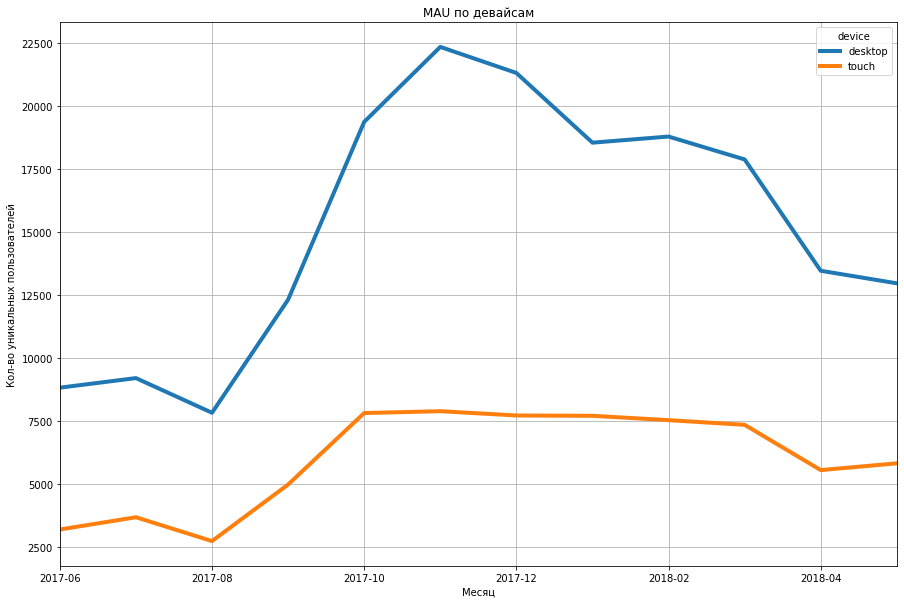

In [20]:
ax = mau_device.plot(kind='line',
                title='MAU по девайсам',
                grid=True, figsize=(15, 10), linewidth=4)
ax.set_xlabel('Месяц')
ax.set_ylabel('Кол-во уникальных пользователей');

In [21]:
wau_device = visits.pivot_table(index='session_week', columns='device', values='uid', aggfunc='nunique')
wau_device.head()

device,desktop,touch
session_week,,
2017-06-01,2738,964
2017-06-08,2209,771
2017-06-15,1934,611
2017-06-22,2003,770
2017-06-29,2005,742


In [22]:
wau_device.describe().T

,count,mean,std,min,25%,50%,75%,max
device,,,,,,,,
desktop,53.0,3762.471698,1414.971889,1261.0,2656.0,3786.0,4905.0,7496.0
touch,53.0,1435.339623,532.812384,511.0,964.0,1571.0,1885.0,2481.0


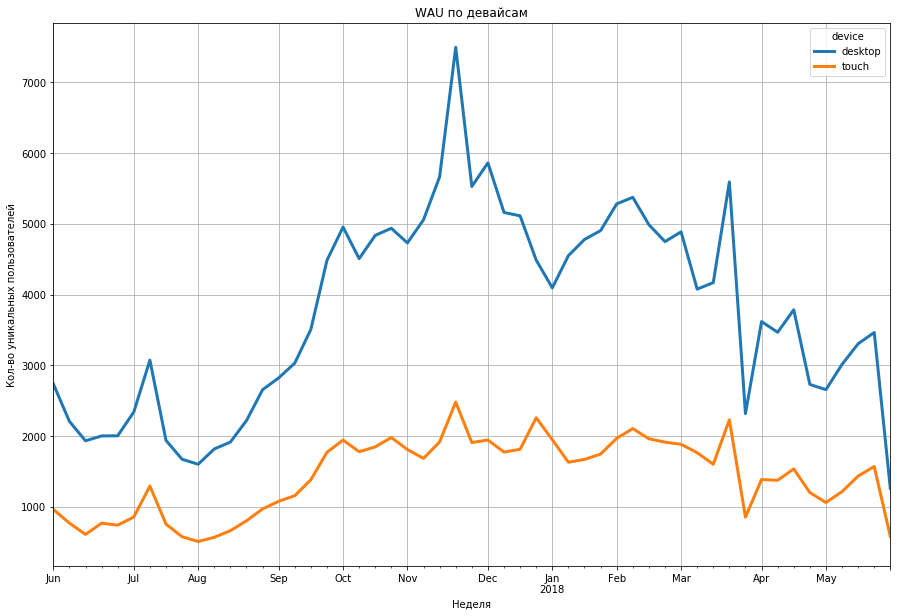

In [23]:
ax = wau_device.plot(kind='line', title='WAU по девайсам', grid=True, figsize=(15, 10), linewidth=3)
ax.set_xlabel('Неделя')
ax.set_ylabel('Кол-во уникальных пользователей');

In [24]:
dau_device = visits.pivot_table(index='session_date', columns='device', values='uid', aggfunc='nunique')
dau_device.head()

device,desktop,touch
session_date,,
2017-06-01,415.0,134.0
2017-06-02,425.0,126.0
2017-06-03,279.0,122.0
2017-06-04,288.0,131.0
2017-06-05,567.0,177.0


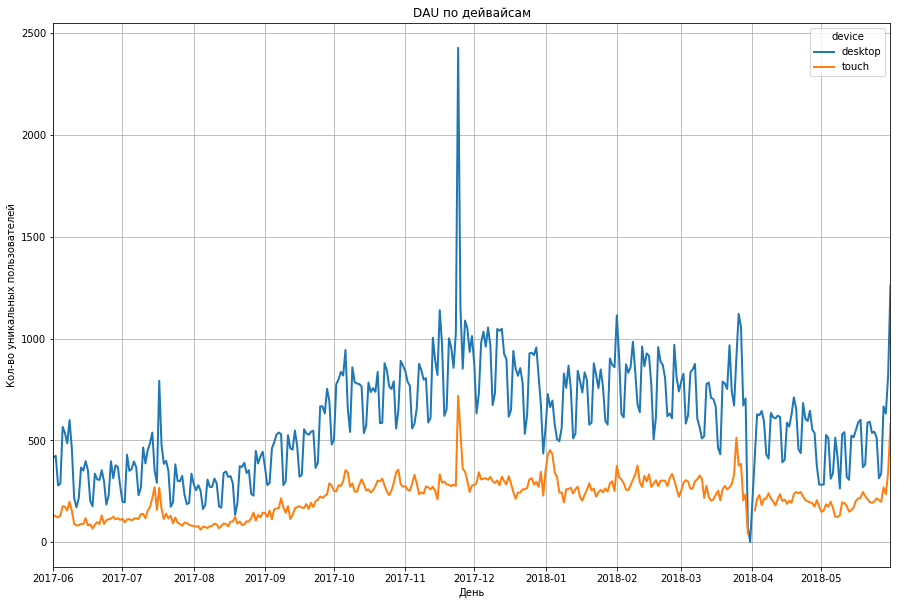

In [25]:
ax = dau_device.plot(kind='line', title='DAU по дейвайсам', grid=True, figsize=(15, 10), linewidth=2)
ax.set_xlabel('День')
ax.set_ylabel('Кол-во уникальных пользователей');

Расчет уникальных пользоваетелй в день / неделю / месяц по устройствам показывает следующие результаты:
1. Количество уникальных пользователей, которые заходят с устройства desktop примерно в 2 раза выше, чем пользователей с touch. Например, в 75% недель (2 квартиль) количество уникальных пользователей desktop составило 4905, когда как touch - 1885;
2. Наблюдается определенный всплеск посещений с октября 2017 года по март 2018. Вероятно, это указывает на сезонность;
3. Визуально бросаются в глаза один выброс во второй половине ноября 2107 и один провал в конце марта 2018. Возможно, в эти дни наблюдались какие-то технические сбои в сервисе.

Рассчитаем аналогичные показатели, но уже по рекламным источникам.

In [26]:
mau_source = visits.pivot_table(index='session_month', columns='source_id', values='uid', aggfunc='nunique')
mau_source.head()

source_id,1,2,3,4,5,6,7,9,10
session_month,,,,,,,,,
2017-06,912.0,1384.0,3757.0,3245.0,2588.0,NaN,2.0,664.0,392.0
2017-07,987.0,1598.0,3628.0,3684.0,3274.0,1.0,2.0,520.0,294.0
2017-08,743.0,1138.0,3053.0,2814.0,2804.0,1.0,1.0,567.0,227.0
2017-09,1330.0,1970.0,5220.0,4798.0,4376.0,NaN,3.0,708.0,445.0
2017-10,2049.0,3101.0,7623.0,8585.0,6668.0,NaN,5.0,944.0,822.0


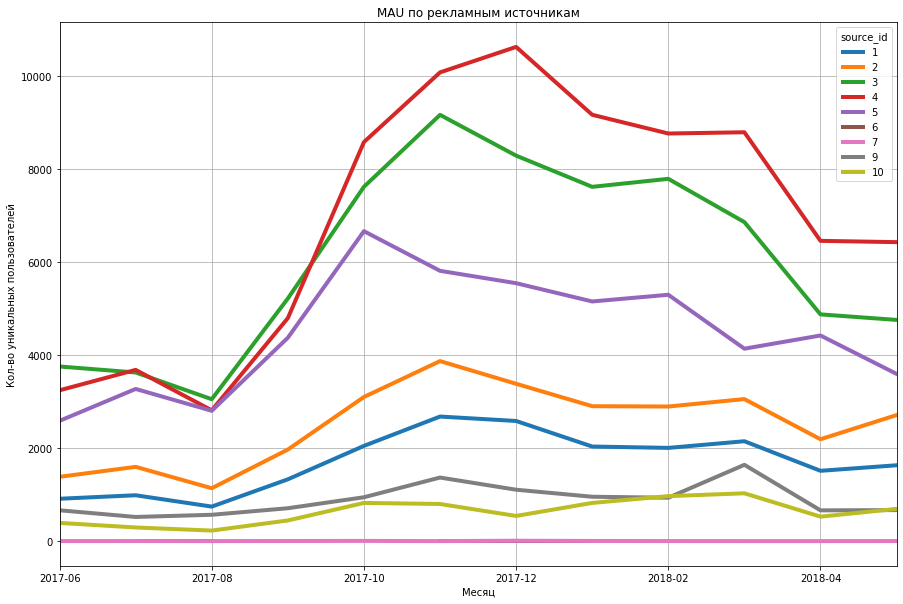

In [27]:
ax = mau_source.plot(kind='line', title='MAU по рекламным источникам', grid=True, figsize=(15, 10), linewidth=4)
ax.set_xlabel('Месяц')
ax.set_ylabel('Кол-во уникальных пользователей');

In [28]:
wau_source = visits.pivot_table(index='session_week', columns='source_id', values='uid', aggfunc='nunique')
wau_source.head()

source_id,1,2,3,4,5,6,7,9,10
session_week,,,,,,,,,
2017-06-01,320.0,476.0,1174.0,903.0,730.0,NaN,1.0,177.0,160.0
2017-06-08,240.0,392.0,959.0,781.0,544.0,NaN,NaN,122.0,100.0
2017-06-15,205.0,313.0,745.0,786.0,395.0,NaN,1.0,142.0,72.0
2017-06-22,187.0,330.0,733.0,672.0,741.0,NaN,NaN,186.0,59.0
2017-06-29,225.0,335.0,764.0,793.0,573.0,1.0,1.0,162.0,65.0


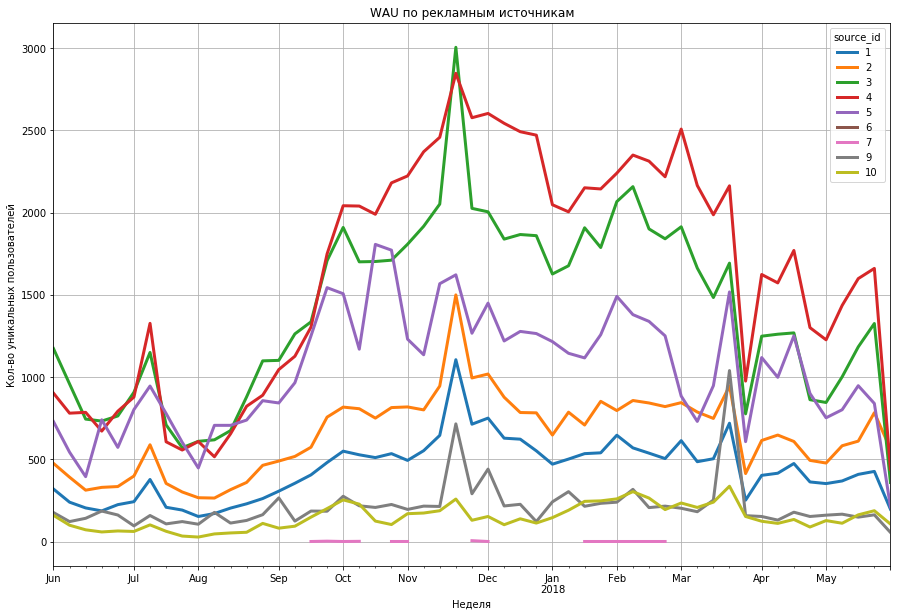

In [29]:
ax = wau_source.plot(kind='line', title='WAU по рекламным источникам', grid=True, figsize=(15, 10), linewidth=3)
ax.set_xlabel('Неделя')
ax.set_ylabel('Кол-во уникальных пользователей');

In [30]:
dau_source = visits.pivot_table(index='session_date', columns='source_id', values='uid', aggfunc='nunique')
dau_source.head()

source_id,1,2,3,4,5,6,7,9,10
session_date,,,,,,,,,
2017-06-01,58.0,76.0,160.0,122.0,102.0,NaN,NaN,47.0,9.0
2017-06-02,49.0,83.0,156.0,141.0,104.0,NaN,NaN,14.0,20.0
2017-06-03,36.0,51.0,112.0,99.0,78.0,NaN,NaN,16.0,19.0
2017-06-04,43.0,46.0,123.0,100.0,91.0,NaN,NaN,13.0,16.0
2017-06-05,68.0,93.0,234.0,152.0,123.0,NaN,NaN,70.0,30.0


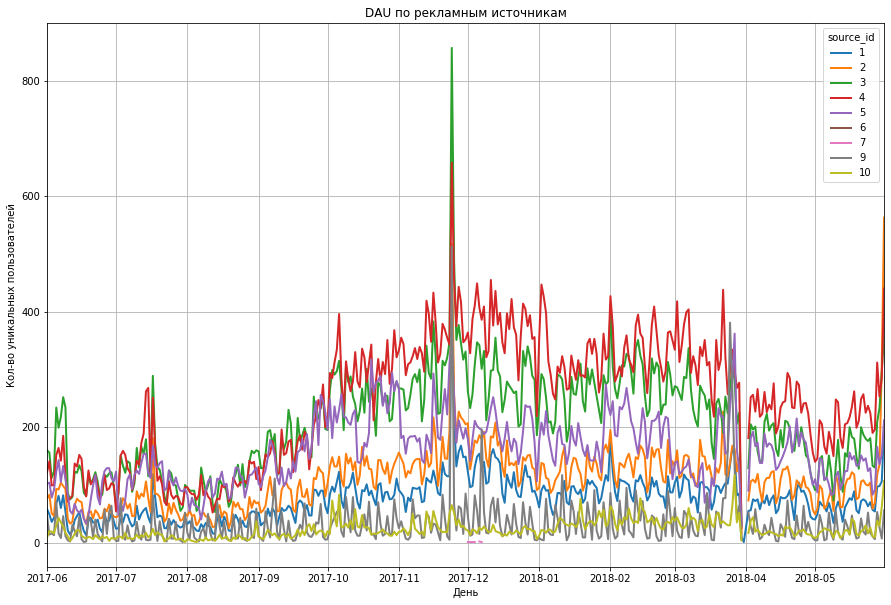

In [31]:
ax = dau_source.plot(kind='line', title='DAU по рекламным источникам', grid=True, figsize=(15, 10), linewidth=2)
ax.set_xlabel('День')
ax.set_ylabel('Кол-во уникальных пользователей');

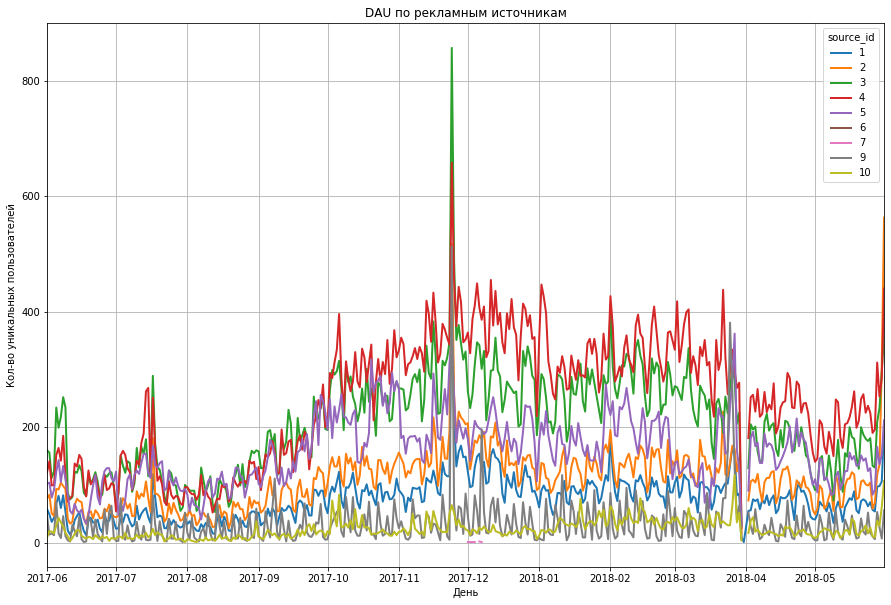

In [32]:
ax = dau_source.plot(kind='line', title='DAU по рекламным источникам', grid=True, figsize=(15, 10), linewidth=2)
ax.set_xlabel('День')
ax.set_ylabel('Кол-во уникальных пользователей');

Выполним расчет показателей по всему бизнесу за рассматриваемый период

In [33]:
mau_total = visits.pivot_table(index='session_month', values='uid', aggfunc='nunique')['uid']
mau_total.mean().round()

20956.0

In [34]:
wau_total = visits.pivot_table(index='session_week', values='uid', aggfunc='nunique')['uid']
wau_total.mean().round()

5156.0

In [35]:
dau_total = visits.pivot_table(index='session_date', values='uid', aggfunc='nunique')['uid']
dau_total.mean().round()

818.0

Полученные результаты по рекламным источникам говорят о следующем:
1. Наиболее популярным истоником является 4 рекламный источник;
2. С августа 2017 наблюдается значительный рост источников 3, 4 и 5, которые сохранили лидерство по количеству уникальных пользователей;
3. Источник 7 не приносит пользователей;
4. Всплеск в ноябре 2017 и падение в конце марта 2018, которые были замечены на предыдущих графиках также видно на данных по рекламным источникам;
5. Таблица visits показывает, что за рассматриваемый период mau составляет 20956, wau 5156, dau 818

#### Определим, сколько происходит сессий в день

Рассмотрим, сколько происходит сессий в день в течение всего периода

In [36]:
sessions_per_day = visits.pivot_table(index='session_date', values='uid', aggfunc='count')
sessions_per_day

,uid
session_date,
2017-06-01,599
2017-06-02,596
2017-06-03,429
2017-06-04,447
2017-06-05,807
...,...
2018-05-27,582
2018-05-28,1041
2018-05-29,942


In [37]:
sessions_per_day.describe().T

,count,mean,std,min,25%,50%,75%,max
uid,364.0,889.021978,383.086457,1.0,575.0,898.0,1153.75,3755.0


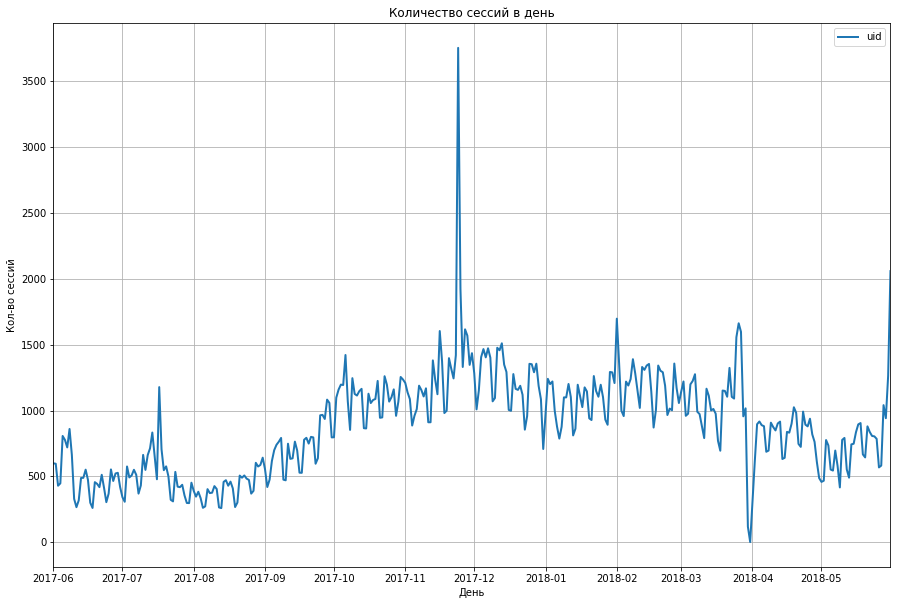

In [38]:
ax = sessions_per_day.plot(kind='line', title='Количество сессий в день', grid=True, figsize=(15, 10), linewidth=2)
ax.set_xlabel('День')
ax.set_ylabel('Кол-во сессий');

В среднем, в день происходит 889 сессий. При этом на данное значение сильно сказывается выброс в виде 3755 посещений в один из дней ноября. 

#### Определим, сколько длится одна сессия

In [39]:
visits['length'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['length'].describe().T

count    323604.000000
mean        714.169516
std        1026.349417
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       42660.000000
Name: length, dtype: float64

In [40]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323604 entries, 0 to 359399
Data columns (total 10 columns):
device           323604 non-null object
start_ts         323604 non-null datetime64[ns]
end_ts           323604 non-null datetime64[ns]
source_id        323604 non-null int64
uid              323604 non-null uint64
session_year     323604 non-null int64
session_month    323604 non-null object
session_week     323604 non-null datetime64[ns]
session_date     323604 non-null object
length           323604 non-null int64
dtypes: datetime64[ns](3), int64(3), object(3), uint64(1)
memory usage: 27.2+ MB


In [41]:
visits_length = visits.pivot_table(index='session_date', values='length')
visits_length

,length
session_date,
2017-06-01,738.626043
2017-06-02,684.320470
2017-06-03,674.869464
2017-06-04,632.434004
2017-06-05,690.996283
...,...
2018-05-27,643.092784
2018-05-28,702.727185
2018-05-29,691.569002


In [42]:
visits.head()

,device,start_ts,end_ts,source_id,uid,session_year,session_month,session_week,session_date,length
0,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4,16879256277535980062,2017,2017-12,2017-12-14,2017-12-20,1080
1,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2,104060357244891740,2018,2018-02,2018-02-15,2018-02-19,1680
3,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9,16174680259334210214,2018,2018-05,2018-05-17,2018-05-20,1440
5,desktop,2017-09-03 21:35:00,2017-09-03 21:36:00,5,16007536194108375387,2017,2017-09,2017-08-31,2017-09-03,60
6,desktop,2018-01-30 11:13:00,2018-01-30 12:09:00,1,6661610529277171451,2018,2018-01,2018-01-25,2018-01-30,3360


In [43]:
visits_length.describe().T

,count,mean,std,min,25%,50%,75%,max
length,364.0,691.411866,77.038257,60.0,652.782474,692.196241,729.194119,1201.840479


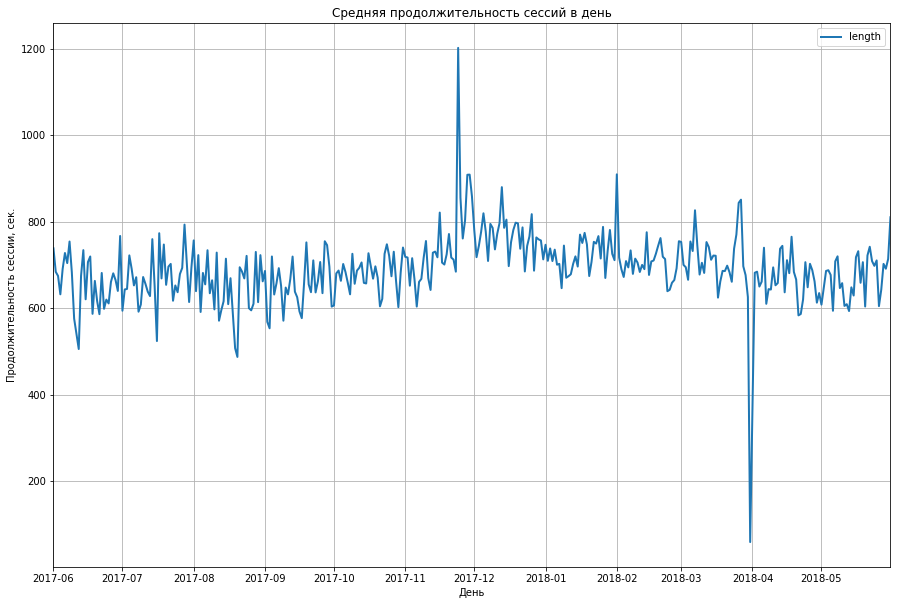

In [44]:
ax = visits_length.plot(kind='line', title='Средняя продолжительность сессий в день', grid=True, figsize=(15, 10), linewidth=2)
ax.set_xlabel('День')
ax.set_ylabel('Продолжительность сессии, сек.');

Уберем выделяющиеся значения и подробнее рассмторим данные

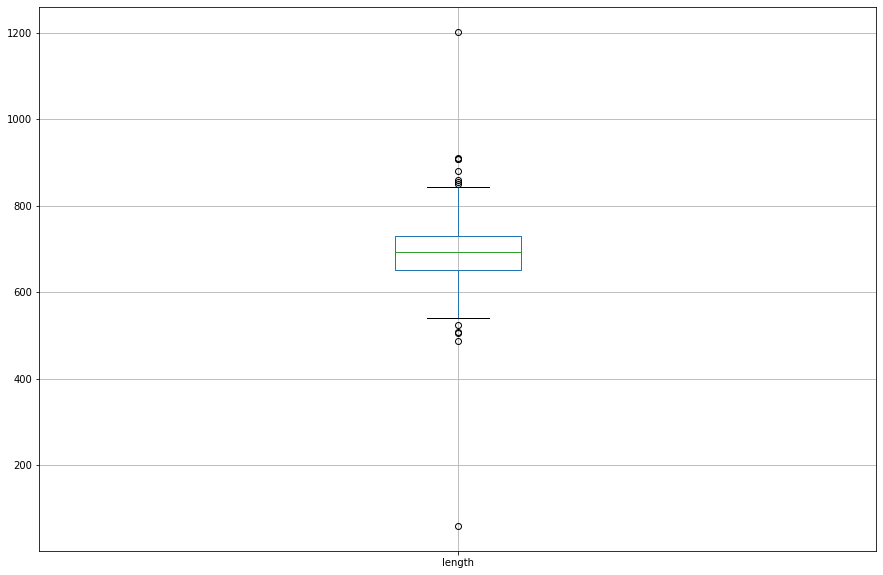

In [45]:
visits_length.boxplot(figsize=(15, 10))

Уберем значения, которые больше 850 и меньше 550 для более точного видения картины

In [46]:
visits_length_filtered = visits_length.query('length < 850 and length > 550')
visits_length_filtered

,length
session_date,
2017-06-01,738.626043
2017-06-02,684.320470
2017-06-03,674.869464
2017-06-04,632.434004
2017-06-05,690.996283
...,...
2018-05-27,643.092784
2018-05-28,702.727185
2018-05-29,691.569002


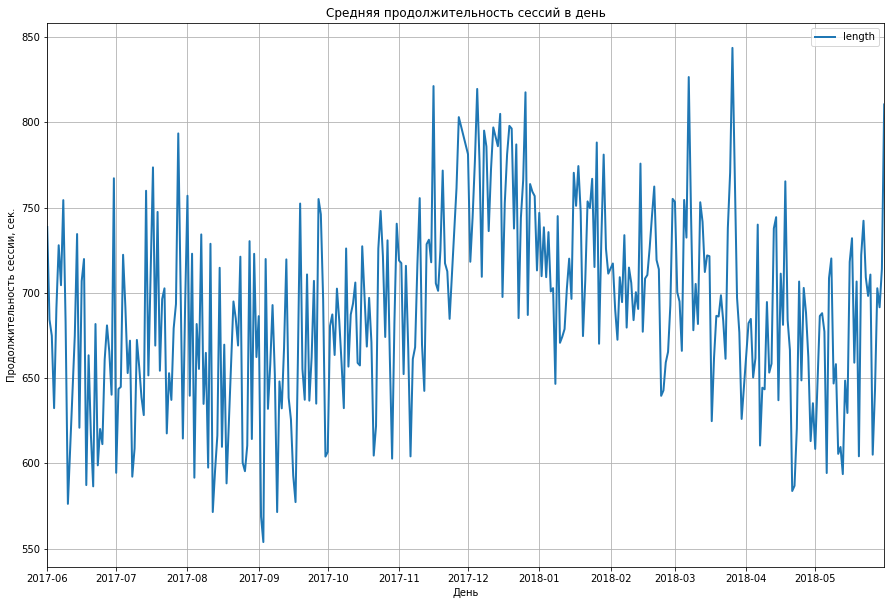

In [47]:
ax = visits_length_filtered.plot(kind='line', title='Средняя продолжительность сессий в день', grid=True, figsize=(15, 10), linewidth=2)
ax.set_xlabel('День')
ax.set_ylabel('Продолжительность сессии, сек.');

Средняя сессия составила 690 секунд. В целом распределение в течение 364 дней в интервале от 500 до 800 секунд. По графику видно, что значения достаточно сильно варьируются изо дня в день. Рассмторим динамикку стандартного отклонения для понимания ситуации.

In [48]:
visits_length_filtered_stats = visits.groupby('session_date')['length'].agg('std')

In [49]:
visits_length_filtered_stats

session_date
2017-06-01    1022.260261
2017-06-02    1074.174046
2017-06-03     918.926167
2017-06-04     796.283539
2017-06-05     948.519510
                 ...     
2018-05-27     843.444329
2018-05-28    1132.762798
2018-05-29     930.224661
2018-05-30    1023.911389
2018-05-31    1089.179080
Name: length, Length: 364, dtype: float64

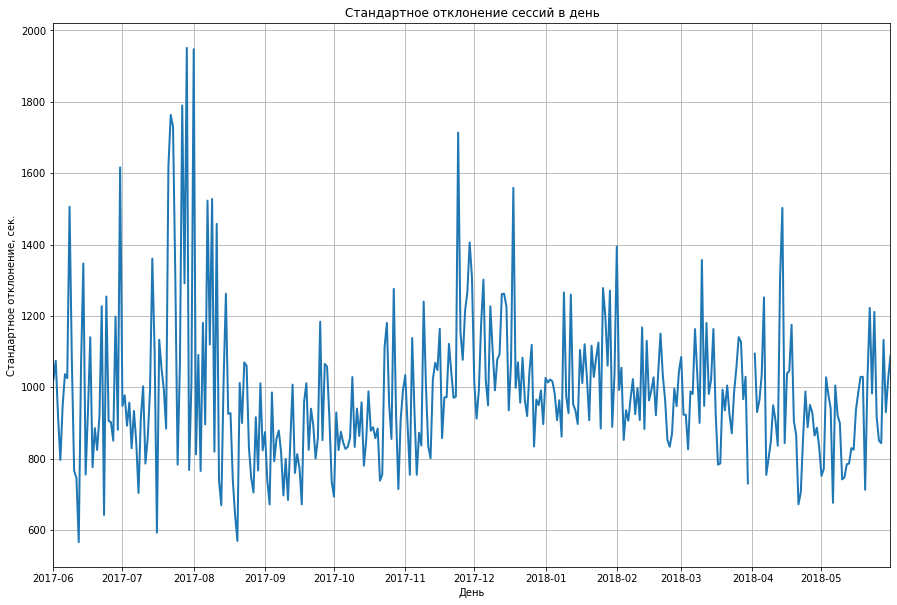

In [50]:
ax = visits_length_filtered_stats.plot(kind='line', title='Стандартное отклонение сессий в день', grid=True, figsize=(15, 10), linewidth=2)
ax.set_xlabel('День')
ax.set_ylabel('Стандартное отклонение, сек.');

Как видно из графика выше, с июня по август средняя продолжительность сессий была подвержена более сильному разбросу, чем в последующие месяцы. В дальнейшем динамика показателя более стабильная, но отклонение по прежнему составляет от 11 до 25 минут

#### Определим, как часто люди возвращаются

Определим Retention Rate по месяцам и устройствам для когорт пользователей

Определим первый месяц активности каждого пользователя и на его основе ссотавим когорты лайфтайма

In [51]:
first_activity_month = visits.groupby('uid')['session_month'].min()
first_activity_month.name = 'first_activity_month'

In [52]:
visits = visits.join(first_activity_month,on='uid')

In [53]:
visits['cohort_lifetime'] = pd.to_datetime(
    visits['session_month']) - pd.to_datetime(visits['first_activity_month'])

In [54]:
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')

In [55]:
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

Добавим данные о первом месяце активности когорт к таблице cohorts и рассчитаем retention

In [56]:
cohorts_first_month = visits.groupby(
    ['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_cohorts_first_month = cohorts_first_month[
    cohorts_first_month['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_cohorts_first_month = initial_cohorts_first_month.rename(columns={'uid':'cohort_users'})
cohorts_first_month = cohorts_first_month.merge(initial_cohorts_first_month,on='first_activity_month')
cohorts_first_month['retention'] = cohorts_first_month['uid']/cohorts_first_month['cohort_users']

Сгруппируем данные по retention по первому месяцу активности польщзователей и рассмотрим изменнеие показателя по каждой когорте. После составим хитмап для наглядности картины

In [57]:
retention_first_month = cohorts_first_month.pivot_table(
    index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_first_month

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,1.0,0.075726,0.050989,0.059739,0.065377,0.067480,0.057720,0.056121,0.050989,0.049727,0.038115,0.043921
2017-07,1.0,0.054545,0.050402,0.055645,0.056660,0.046512,0.044059,0.044059,0.037886,0.027315,0.027061,NaN
2017-08,1.0,0.074452,0.060451,0.060451,0.047970,0.041459,0.036249,0.037660,0.027133,0.024745,NaN,NaN
2017-09,1.0,0.083570,0.067769,0.049322,0.038083,0.036959,0.035372,0.022876,0.022744,NaN,NaN,NaN
2017-10,1.0,0.078129,0.050811,0.037811,0.033648,0.031184,0.020775,0.019798,NaN,NaN,NaN,NaN
2017-11,1.0,0.078183,0.042733,0.037824,0.032593,0.021729,0.020602,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.054668,0.036518,0.030178,0.019453,0.017716,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.057794,0.037817,0.024352,0.019249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.056561,0.024290,0.019184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


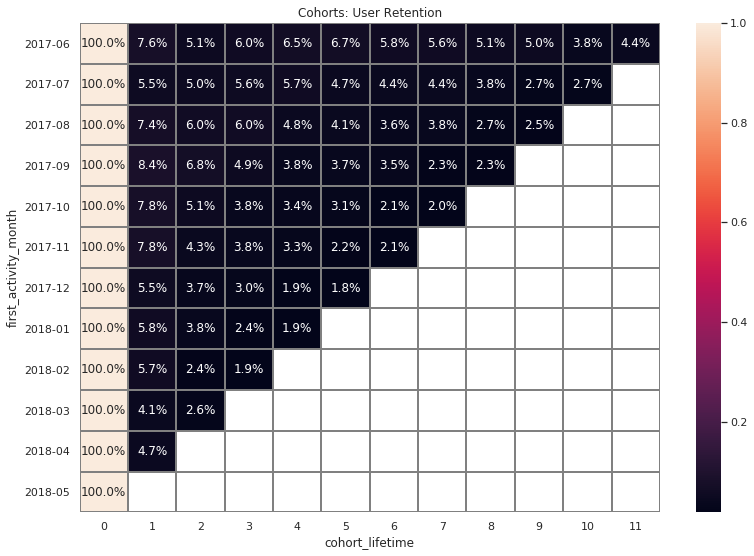

In [58]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_first_month, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Как видно из результатов на графике, после первого месяца остается не более 9% пользователей в последующие периоды. Наибольший retention демонстрирует когорта 2017-06 - 4.4% к 11 лайфтайму, в остальных группах retention на последний месяц составляет от 1.8% до 2.7%

Рассчитаем retention по девайсам - desktop и touch. Для этого используем рассчитанные выше когорты и сгруппируем данные по девайсам

In [59]:
cohorts_devices = visits.groupby(
    ['device','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [60]:
initial_cohorts_devices = cohorts_devices[
    cohorts_devices['cohort_lifetime'] == 0][['device','uid']]
initial_cohorts_devices = initial_cohorts_devices.rename(columns={'uid':'cohort_users'})
cohorts_devices = cohorts_devices.merge(initial_cohorts_devices,on='device')
cohorts_devices['retention'] = cohorts_devices['uid']/cohorts_devices['cohort_users']

Сгруппируем данные по retention по устройствам пользователей и рассмотрим изменнеие показателя по каждой когорте. После составим хитмап по полученной таблице

In [61]:
retention_device = cohorts_devices.pivot_table(
    index='device',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_device

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,1.0,0.062371,0.038925,0.031444,0.025706,0.021340,0.016227,0.012379,0.008766,0.006243,0.004124,0.002792
touch,1.0,0.055668,0.033775,0.025942,0.020423,0.015483,0.012575,0.009286,0.006692,0.004280,0.003206,0.002214


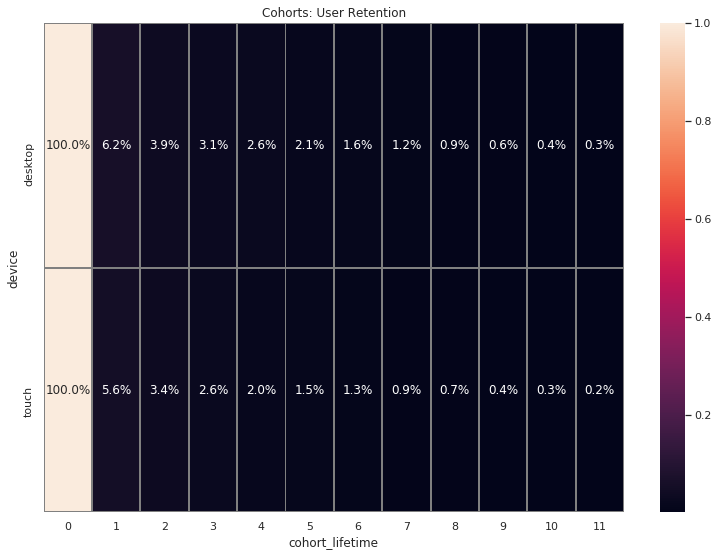

In [62]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_device, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Данные говорят о том, что удержание по устройством имеет схожую динамику. Устройства desktop немного впереди

Аналогичным образом рассчитаем ударжание по когортам, составленным по рекламным источникам привлечения пользователей

In [63]:
cohorts_source = visits.groupby(
    ['source_id','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_cohorts_source = cohorts_source[
    cohorts_source['cohort_lifetime'] == 0][['source_id','uid']]
initial_cohorts_source = initial_cohorts_source.rename(columns={'uid':'cohort_users'})
cohorts_source = cohorts_source.merge(initial_cohorts_source,on='source_id')
cohorts_source['retention'] = cohorts_source['uid']/cohorts_source['cohort_users']

In [64]:
retention_source = cohorts_source.pivot_table(
    index='source_id',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_source

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,1.0,0.126955,0.063580,0.051166,0.044376,0.034842,0.027641,0.022428,0.014403,0.013100,0.008848,0.006996
2,1.0,0.147072,0.087354,0.067549,0.056080,0.045471,0.038397,0.027484,0.021270,0.015814,0.011519,0.008185
3,1.0,0.042146,0.028232,0.025569,0.020016,0.016368,0.012897,0.010121,0.007119,0.004730,0.003519,0.002147
4,1.0,0.061651,0.038148,0.029569,0.024073,0.020492,0.015128,0.011313,0.008229,0.005306,0.003771,0.002353
5,1.0,0.042440,0.025532,0.019527,0.014480,0.012777,0.009008,0.007006,0.005026,0.003471,0.002215,0.001874
6,1.0,NaN,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,0.032258,NaN,NaN,0.032258,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.154332,0.125964,0.089423,0.082794,0.062751,0.043941,0.033765,0.026827,0.020352,0.009559,0.005859
10,1.0,0.047685,0.023842,0.019869,0.018493,0.010240,0.008712,0.009629,0.008406,0.004279,0.002751,0.001681


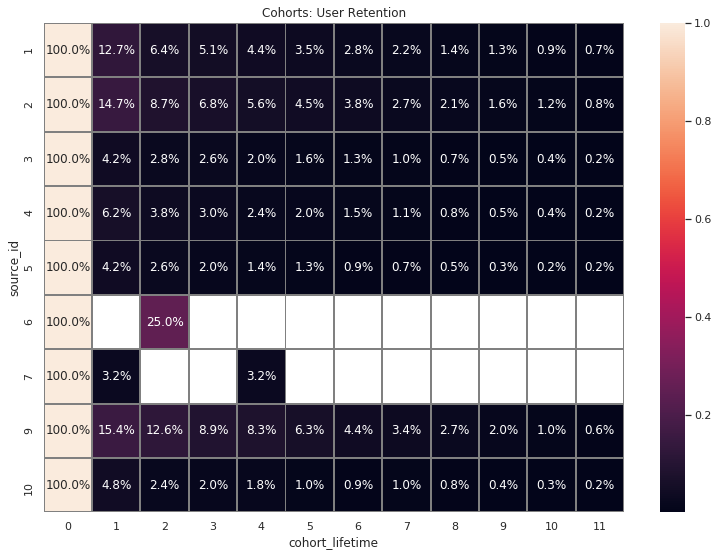

In [65]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_source, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Среди рекламных источников выделяются 1, 2 и 9 источники, которые сохраняют не менее 10% пользователей на следующий месяц. По 6 и 7 источнику данные для анализа отсутствуют

Выводы по Продукту:
1. Посещений пользователей на desktop значительно больше посещений на устройствах touch
2. На графике уникальных пользователей заметна сезонность с октября 2017 по март 2018 
3. На графиках уникальных пользователей и продолжительности сессий выделяются выброс во второй половине ноября 2107 и провал в конце марта 2018
4. Наиболее популярным истоником является 4 рекламный источник. С августа 2017 наблюдается значительный рост источников 3, 4 и 5, которые сохранили лидерство по количеству уникальных пользователей
5. Retention Rate на второй месяц lifetime когорт составляет 4,1 - 8,4%. Когорта 2017-06 сохранила 4,4: пользователей на десятый месяц, когда как другие когорты демонстрируют меньший уровень удержания на последний фиксируемый месяц - от 1,8 до 2,7%
6. Retention Rate по устройствам примерно одинаковый, desktop показывает несколько лучшие результаты. На десятый месяц остается 0,3% пользователей
7. Среди рекламных источников Retention Rate наибольший у 1,2 и 9 исчточника. Источники 6 и 7 не демонстрируют свою эффективность, так как не привлекают пользователей.

## 2.2 Продажи

#### Определим, когда люди начинают покупать

Учтем первый визит каждого пользователя на сайт и присоедними покупки для определения времени

In [66]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')

In [67]:
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')

In [68]:
first_start_ts = visits.groupby('uid')['start_ts'].min()
first_buy_ts = orders.groupby('uid')['buy_ts'].min()

In [69]:
first_purchase = first_start_ts.to_frame().join(first_buy_ts.to_frame(), on='uid', how='inner')
first_purchase = first_purchase[first_purchase['buy_ts'] >= first_purchase['start_ts']]
first_purchase['first_purchase'] = first_purchase['buy_ts'] - first_purchase['start_ts']
first_purchase

,start_ts,buy_ts,first_purchase
uid,,,
313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106 days 23:02:00
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00
2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0 days 01:19:00
2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0 days 19:44:00
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00
...,...,...,...
18442290965339407211,2018-02-05 19:35:00,2018-02-05 19:39:00,0 days 00:04:00
18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00,0 days 00:07:00
18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00,231 days 11:03:00


In [70]:
first_purchase['first_purchase'].describe(percentiles=(.25, .5, .7, .8, .9))

count                      35886
mean     15 days 17:50:18.485203
std      45 days 10:32:13.572973
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:15:00
70%              0 days 08:56:30
80%              5 days 03:20:00
90%             51 days 11:22:30
max            363 days 07:04:00
Name: first_purchase, dtype: object

Таблица с данными о первой покупке каждого пользователя показывает, что в половине случае первая покупка происходит в течение 15 минут. 70% пользователей покупают в течение 9 часов. 

#### Определим, сколько раз пользователи покупают за период

Для ответа на вопрос определим среднее число покупок в месяц

In [71]:
report = (visits.sort_values(by=['uid', 'start_ts'])
                .groupby(['uid', 'session_month'])
                .agg({'source_id':'first', 'device':'first'})
                .reset_index()
         )

In [72]:
report = report.merge(orders.groupby(['uid', 'purchase_month']).agg({'revenue':'sum', 'buy_ts':'count'}),
                     left_on = ['uid', 'session_month'],
                     right_on = ['uid', 'purchase_month'],
                     how = 'left'
                     ).rename(columns = {'buy_ts': 'purchase'})
report

,uid,session_month,source_id,device,revenue,purchase
0,11863502262781,2018-03-01,3,touch,NaN,NaN
1,49537067089222,2018-02-01,2,touch,NaN,NaN
2,297729379853735,2017-06-01,3,desktop,NaN,NaN
3,313578113262317,2017-09-01,2,desktop,NaN,NaN
4,313578113262317,2018-02-01,2,desktop,NaN,NaN
...,...,...,...,...,...,...
251463,18446403737806311543,2017-11-01,5,desktop,NaN,NaN
251464,18446556406699109058,2018-01-01,3,touch,NaN,NaN
251465,18446621818809592527,2017-12-01,4,desktop,NaN,NaN
251466,18446621818809592527,2018-05-01,4,desktop,NaN,NaN


In [73]:
report = (report.groupby(['device', 'session_month'])
               .agg({'uid':'nunique', 'purchase':'sum', 'revenue':['count', 'sum']})
         )

In [74]:
report.columns = ['MAU', 'purchases', 'paying MAU', 'revenue']

In [75]:
report = report.reset_index()
report

,device,session_month,MAU,purchases,paying MAU,revenue
0,desktop,2017-06-01,8755,1974.0,1684,8205.86
1,desktop,2017-07-01,9119,1839.0,1526,9841.57
2,desktop,2017-08-01,7777,1422.0,1130,7045.57
3,desktop,2017-09-01,12222,2661.0,2099,15021.67
4,desktop,2017-10-01,19156,4452.0,3638,22291.53
5,desktop,2017-11-01,22085,4364.0,3489,20514.01
6,desktop,2017-12-01,21096,4760.0,3691,31033.70
7,desktop,2018-01-01,18357,3504.0,2815,15064.27
8,desktop,2018-02-01,18574,3838.0,2982,20012.61
9,desktop,2018-03-01,17678,3886.0,2957,22090.41


In [76]:
report_desktop = report[report['device'] == 'desktop']
report_desktop = report_desktop.set_index('session_month')
report_desktop

,device,MAU,purchases,paying MAU,revenue
session_month,,,,,
2017-06-01,desktop,8755,1974.0,1684,8205.86
2017-07-01,desktop,9119,1839.0,1526,9841.57
2017-08-01,desktop,7777,1422.0,1130,7045.57
2017-09-01,desktop,12222,2661.0,2099,15021.67
2017-10-01,desktop,19156,4452.0,3638,22291.53
2017-11-01,desktop,22085,4364.0,3489,20514.01
2017-12-01,desktop,21096,4760.0,3691,31033.70
2018-01-01,desktop,18357,3504.0,2815,15064.27
2018-02-01,desktop,18574,3838.0,2982,20012.61


In [77]:
report_touch = report[report['device'] == 'touch']
report_touch = report_touch.set_index('session_month')
report_touch

,device,MAU,purchases,paying MAU,revenue
session_month,,,,,
2017-06-01,touch,3130,349.0,311,1192.78
2017-07-01,touch,3606,439.0,379,2168.33
2017-08-01,touch,2688,283.0,244,1328.22
2017-09-01,touch,4895,555.0,485,2532.13
2017-10-01,touch,7638,944.0,767,4546.97
2017-11-01,touch,7660,974.0,755,5180.76
2017-12-01,touch,7497,1035.0,848,3745.53
2018-01-01,touch,7573,803.0,686,2775.77
2018-02-01,touch,7381,976.0,823,3684.71


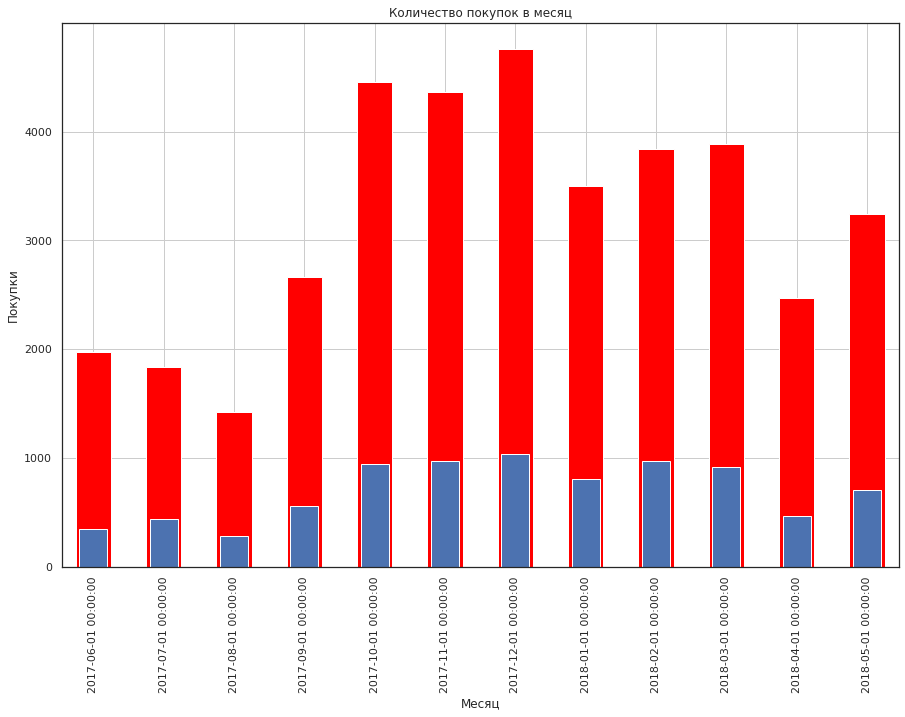

In [78]:
ax = report_desktop['purchases'].plot(kind='bar', title='Количество покупок в месяц', grid=True, figsize=(15,10), color='Red', width=0.5)
report_touch['purchases'].plot(kind='bar', grid=True, figsize=(15,10), width=0.4, ax=ax)
ax.set_xlabel('Месяц')
ax.set_ylabel('Покупки');

Количество покупок значительно отличается между пользователями на desktop и touch. Максимальное значение desktop составило 4760 покупок в декабре 2017 года. В этом же месяце были максимальные цирфы по покупкам среди пользователей touch - 1035. Наличие сезонности также подтверждено.

#### Определим, какой средний чек

На основе данных в таблице report посчитаем средние чеки пользователей desktop и touch

In [79]:
report_desktop['avg_bill'] = report_desktop['revenue'] / report_desktop['purchases']
report_desktop

,device,MAU,purchases,paying MAU,revenue,avg_bill
session_month,,,,,,
2017-06-01,desktop,8755,1974.0,1684,8205.86,4.156971
2017-07-01,desktop,9119,1839.0,1526,9841.57,5.351588
2017-08-01,desktop,7777,1422.0,1130,7045.57,4.954691
2017-09-01,desktop,12222,2661.0,2099,15021.67,5.645122
2017-10-01,desktop,19156,4452.0,3638,22291.53,5.007082
2017-11-01,desktop,22085,4364.0,3489,20514.01,4.700736
2017-12-01,desktop,21096,4760.0,3691,31033.70,6.519685
2018-01-01,desktop,18357,3504.0,2815,15064.27,4.299164
2018-02-01,desktop,18574,3838.0,2982,20012.61,5.214333


In [80]:
report_touch['avg_bill'] = report_touch['revenue'] / report_touch['purchases']
report_touch

,device,MAU,purchases,paying MAU,revenue,avg_bill
session_month,,,,,,
2017-06-01,touch,3130,349.0,311,1192.78,3.417708
2017-07-01,touch,3606,439.0,379,2168.33,4.939248
2017-08-01,touch,2688,283.0,244,1328.22,4.693357
2017-09-01,touch,4895,555.0,485,2532.13,4.562396
2017-10-01,touch,7638,944.0,767,4546.97,4.816706
2017-11-01,touch,7660,974.0,755,5180.76,5.319055
2017-12-01,touch,7497,1035.0,848,3745.53,3.618870
2018-01-01,touch,7573,803.0,686,2775.77,3.456750
2018-02-01,touch,7381,976.0,823,3684.71,3.775318


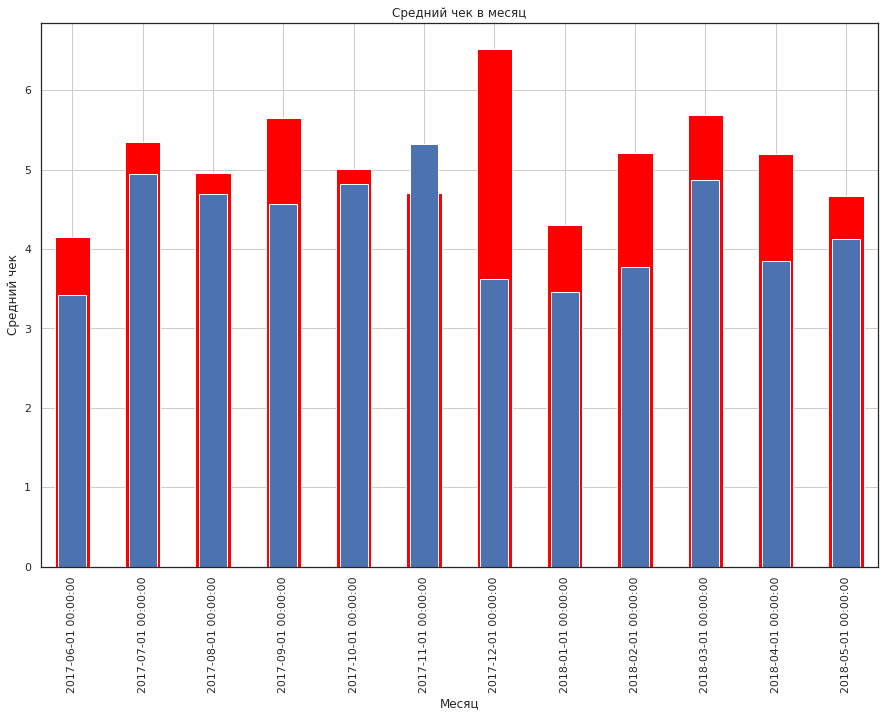

In [81]:
ax = report_desktop['avg_bill'].plot(kind='bar', title='Средний чек в месяц', grid=True, figsize=(15,10), color='Red', width=0.5)
report_touch['avg_bill'].plot(kind='bar', grid=True, figsize=(15,10), width=0.4, ax=ax)
ax.set_xlabel('Месяц')
ax.set_ylabel('Средний чек');

Средний чек на протяжении всего рассматриваемого периода больше у пользователей desktop. Но в ноябре 2017 средняя покупка пользователей touch была дороже. В течение периода средний чек отличается между группами незначительно, кроме декабря 2017. В этот месяц средний чек пользоваетелй touch составил 3.6 (один из минимальных показателей), тогда как desktop - 6.5 (максимальный показатель).

#### Определим, сколько денег приносит пользователь (LTV)

Составим профили пользователей для расчета пожизненной ценности клиента

In [82]:
users = (visits.sort_values(by=['uid', 'start_ts'])
               .groupby('uid')
               .agg({'start_ts':'first', 'source_id':'first', 'device':'first'})
               .rename(columns={'start_ts':'acquisition_ts'}))
users['acquisition_date'] = users['acquisition_ts'].dt.date
users['acquisition_month'] = users['acquisition_ts'].astype('datetime64[M]')

In [83]:
costs['acquisition_date'] = costs['dt'].dt.date

In [84]:
users = (users.reset_index()
              .set_index(['source_id', 'acquisition_date'])
              .join(costs.set_index(['source_id', 'acquisition_date']), how='left'))

In [85]:
user_cost = (users.groupby(['source_id', 'acquisition_date'])
                  .agg({'device':'count', 'costs':'max'})
                  .rename(columns={'device':'users'}))
user_cost['acquisition_cost'] = user_cost['costs'] / user_cost['users']

In [86]:
users = users.join(user_cost['acquisition_cost'], how='left').reset_index()
users = users.set_index('uid')[['acquisition_ts', 'acquisition_date', 'acquisition_month', 
                               'source_id', 'device', 'acquisition_cost']]

In [87]:
users = users.join(orders.groupby('uid').agg({'buy_ts':'min'}).rename(columns={'buy_ts':'first_purchase_dt'}), how='left')
users['payer'] = ~users['first_purchase_dt'].isna()

In [88]:
users.head()

,acquisition_ts,acquisition_date,acquisition_month,source_id,device,acquisition_cost,first_purchase_dt,payer
uid,,,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.671111,2017-09-11 00:06:00,True
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.671111,NaT,False
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.671111,2017-06-01 09:23:00,True
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.671111,2017-06-01 16:47:00,True
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.671111,NaT,False


Профили пользователей составлены, рассчитаем ltv

In [89]:
dimentions = ['acquisition_month']
cohorts = (users.groupby(dimentions)
                .agg({'payer':'sum', 'acquisition_cost':'sum'})
                .rename(columns={'payer':'cohort_size'}))
cohorts['cac'] = cohorts['acquisition_cost'] / cohorts['cohort_size']
cohorts

,cohort_size,acquisition_cost,cac
acquisition_month,,,
2017-06-01,2798.0,18015.00,6.438528
2017-07-01,2399.0,18221.19,7.595327
2017-08-01,1670.0,14789.17,8.855790
2017-09-01,3007.0,24360.36,8.101217
2017-10-01,4602.0,36322.88,7.892847
2017-11-01,4210.0,37907.88,9.004247
2017-12-01,4030.0,38306.03,9.505218
2018-01-01,3081.0,33518.52,10.879104
2018-02-01,3204.0,32707.71,10.208399


In [90]:
ltv = orders.set_index('uid').join(users, how='left')[['acquisition_month', 'source_id', 'device',
                                                       'purchase_month', 'revenue']]
ltv

,acquisition_month,source_id,device,purchase_month,revenue
uid,,,,,
9223707061355654945,2017-10-01,9.0,touch,2017-10-01,4.64
9224005701666002943,2017-12-01,5.0,desktop,2017-12-01,3.36
9224005701666002943,2017-12-01,5.0,desktop,2018-03-01,3.67
9225406053864431006,2017-09-01,4.0,desktop,2017-12-01,0.43
9225479525411867039,2018-02-01,4.0,touch,2018-02-01,7.33
...,...,...,...,...,...
9221059331469344216,2017-12-01,4.0,desktop,2017-12-01,0.98
9221809908447127809,2017-12-01,4.0,desktop,2017-12-01,1.34
9222179515197516675,2018-02-01,1.0,desktop,2018-02-01,2.20


In [91]:
ltv = ltv[ltv['purchase_month'] >= ltv['acquisition_month']]

In [92]:
ltv['age_month'] = ((ltv['purchase_month'] - ltv['acquisition_month']) / np.timedelta64(1, 'M')).round().astype('int').copy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
ltv = ltv.groupby(dimentions + ['age_month']).agg({'revenue':'sum'})

In [94]:
ltv = ltv.pivot_table(index=dimentions, columns='age_month', values='revenue', aggfunc='sum')
ltv = ltv.cumsum(axis=1)

In [95]:
ltv = cohorts[['cohort_size']].join(ltv)
ltv

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11
acquisition_month,,,,,,,,,,,,,
2017-06-01,2798.0,9398.64,11949.95,13343.81,17131.46,20747.02,23411.05,26791.88,28966.86,31248.51,34689.77,36820.96,38274.19
2017-07-01,2399.0,9878.15,10928.09,12017.23,13173.02,14107.82,14923.63,15563.71,16278.66,16968.61,17588.01,18102.97,NaN
2017-08-01,1670.0,6248.24,7238.87,8251.97,9112.40,9915.67,10415.30,10825.44,12063.49,12868.91,13232.10,NaN,NaN
2017-09-01,3007.0,12193.41,15789.96,17808.86,28241.97,29523.82,31419.02,32337.00,32829.48,33224.39,NaN,NaN,NaN
2017-10-01,4602.0,18386.50,22021.29,23269.19,24285.68,25227.58,26068.82,26598.89,27241.21,NaN,NaN,NaN,NaN
2017-11-01,4210.0,16739.92,19384.69,20692.04,22073.85,23108.36,23744.19,24376.23,NaN,NaN,NaN,NaN,NaN
2017-12-01,4030.0,16792.09,18478.89,22664.90,27736.16,29272.18,31017.11,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3081.0,10635.78,12498.39,13637.69,13928.09,14439.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3204.0,11611.73,13498.14,14168.91,15373.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
ltv = ltv.div(ltv['cohort_size'], axis=0).drop(columns=['cohort_size'])

In [97]:
cohorts[['cohort_size', 'cac']].join(ltv.fillna(''))

,cohort_size,cac,0,1,2,3,4,5,6,7,8,9,10,11
acquisition_month,,,,,,,,,,,,,,
2017-06-01,2798.0,6.438528,3.359056,4.270890,4.76905,6.12275,7.41495,8.36707,9.57537,10.3527,11.1682,12.3981,13.1597,13.6791
2017-07-01,2399.0,7.595327,4.117612,4.555269,5.00927,5.49105,5.88071,6.22077,6.48758,6.7856,7.0732,7.33139,7.54605,
2017-08-01,1670.0,8.855790,3.741461,4.334653,4.9413,5.45653,5.93753,6.23671,6.4823,7.22365,7.70593,7.92341,,
2017-09-01,3007.0,8.101217,4.055008,5.251068,5.92247,9.39208,9.81836,10.4486,10.7539,10.9177,11.049,,,
2017-10-01,4602.0,7.892847,3.995328,4.785156,5.05632,5.2772,5.48187,5.66467,5.77985,5.91943,,,,
2017-11-01,4210.0,9.004247,3.976228,4.604439,4.91497,5.24319,5.48892,5.63995,5.79008,,,,,
2017-12-01,4030.0,9.505218,4.166772,4.585333,5.62404,6.88242,7.26357,7.69655,,,,,,
2018-01-01,3081.0,10.879104,3.452055,4.056602,4.42638,4.52064,4.68655,,,,,,,
2018-02-01,3204.0,10.208399,3.624135,4.212903,4.42226,4.79829,,,,,,,,


Выводы по Продажам:
1. Таблица с данными о первой покупке каждого пользователя показывает, что в половине случае первая покупка происходит в течение 15 минут. 70% пользователей покупают в течение 9 часов;
2. Количество покупок значительно отчается по пользователям desktop и touch. Максимальное значение desktop составило 4760 покупок в декабре 2017 года. В этом же месяце были максимальные цирфы по покупкам среди пользователей touch - 1035. Наличие сезонности также подтверждено;
3. Средний чек на протяжении всего рассматриваемого периода больше у пользователей desktop. Но в ноябре 2017 средняя покупка пользователей touch была дороже. В течение периода средний чек отличается между группами незначительно, кроме декабря 2017. В этот месяц средний чек пользоваетелй touch составил 3.6 (один из минимальных показателей), тогда как desktop - 6.5 (максимальный показатель);
4. LTV пользователей, разделенных на когорты по месяцу прихода в сервис показывает, что через полгода пользователь приносит от 5.9 до 10.9 у.е. 

## 2.3 Маркетинг

#### Определим, сколько денег потратили всего / на каждый источник / по времени

In [98]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
source_id           2542 non-null int64
dt                  2542 non-null datetime64[ns]
costs               2542 non-null float64
acquisition_date    2542 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 79.6+ KB


In [99]:
costs_total = costs['costs'].sum()
costs_total

329131.62

Общая сумма затрат - 329131.62

In [100]:
costs_by_source = costs.groupby('source_id')['costs'].agg('sum')
costs_by_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

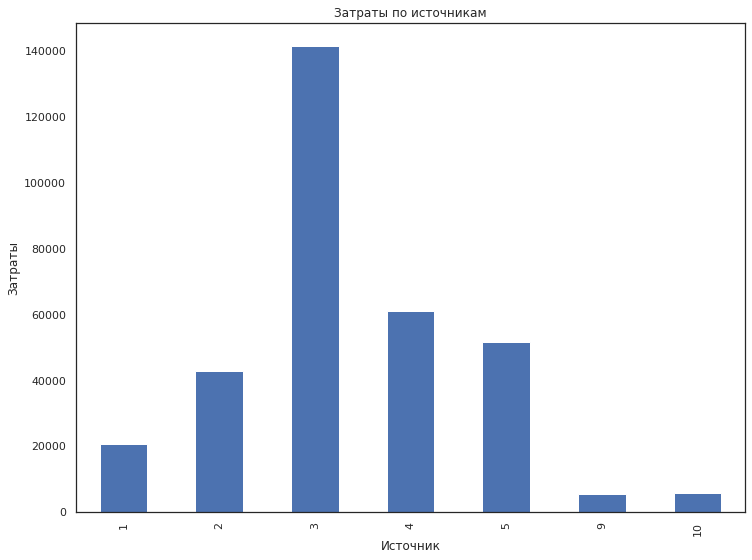

In [101]:
ax = costs_by_source.plot(kind='bar', title='Затраты по источникам', figsize=(12,9))
ax.set_xlabel('Источник')
ax.set_ylabel('Затраты');

In [102]:
costs['acquisition_month'] = costs['acquisition_date'].astype('datetime64[M]')

In [103]:
costs_by_month = costs.groupby('acquisition_month')['costs'].agg('sum')
costs_by_month

acquisition_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

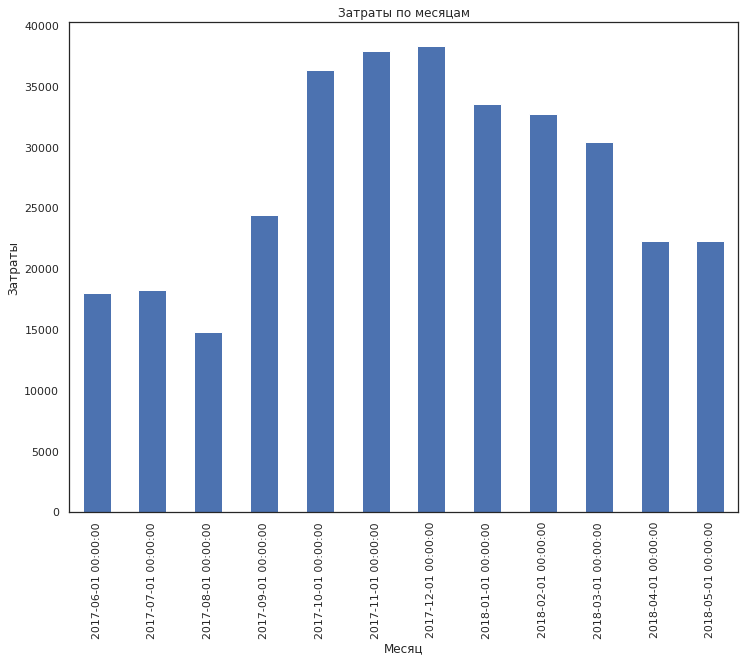

In [104]:
ax = costs_by_month.plot(kind='bar', title='Затраты по месяцам', figsize=(12,9))
ax.set_xlabel('Месяц')
ax.set_ylabel('Затраты');

Структура расходов за рассматриваемый период говорит о следующем:
1. Всего потрачено 329131.62
2. Наиболее "дорого" обходится источник номер 3
3. На источники 6,7 и 8 не было потрачено средств
4. Источники 9 и 10 потребовали меньше всего средств - 5517.49 и 5822.49 соответственно
5. Помесячная динамика указывает на повышенные расходы с октября по март

#### Определим, сколько стоило привлечение одного покупателя из каждого источника

In [105]:
dimentions_source = ['source_id']
cohorts_source = (users.groupby(dimentions_source)
                .agg({'payer':'sum', 'acquisition_cost':'sum'})
                .rename(columns={'payer':'cohort_size'}))
cohorts_source['cac'] = cohorts_source['acquisition_cost'] / cohorts_source['cohort_size']
cohorts_source

,cohort_size,acquisition_cost,cac
source_id,,,
1,2964.0,20833.27,7.028769
2,3515.0,42806.04,12.178105
3,10248.0,141321.63,13.790167
4,10113.0,61073.60,6.039118
5,6847.0,51756.40,7.558989
6,0.0,0.00,NaN
7,1.0,0.00,0.000000
9,1087.0,5444.80,5.009016
10,1306.0,5821.12,4.457213


Таблица выше позволяет сделать следующие выводы:
1. Источники 6 и 7 не работали в рассматриваемом периоде
2. Больше всего привлекли источники 3 и 4
3. При этом источник 4 был в 2 раза дешевле источника 3

#### Определим, на сколько окупились расходы (ROI)

In [106]:
dimentions_roi = ['acquisition_month']
cohorts_roi = (users.groupby(dimentions)
                .agg({'payer':'sum', 'acquisition_cost':'sum'})
                .rename(columns={'payer':'cohort_size'}))
cohorts_roi['cac'] = cohorts_roi['acquisition_cost'] / cohorts_roi['cohort_size']

In [107]:
ltv_roi = orders.set_index('uid').join(users, how='left')[['acquisition_month', 'source_id', 'device',
                                                       'purchase_month', 'revenue']]

In [108]:
ltv_roi = ltv_roi[ltv_roi['purchase_month'] >= ltv_roi['acquisition_month']]

In [109]:
ltv_roi['age_month'] = (
    (ltv_roi['purchase_month'] - ltv_roi['acquisition_month']) / np.timedelta64(1, 'M')).round().astype('int').copy()

In [110]:
ltv_roi = ltv_roi.groupby(dimentions + ['age_month']).agg({'revenue':'sum'})

In [111]:
ltv_roi = ltv_roi.pivot_table(index=dimentions, columns='age_month', values='revenue', aggfunc='sum')
ltv_roi = ltv_roi.cumsum(axis=1)

In [112]:
ltv_roi = cohorts_roi[['cohort_size']].join(ltv_roi)

In [113]:
ltv_roi = ltv_roi.div(ltv_roi['cohort_size'], axis=0).drop(columns=['cohort_size'])

In [114]:
ltv_roi = cohorts_roi[['cac']].join(ltv_roi)

In [115]:
ltv_roi = ltv_roi.div(ltv_roi['cac'], axis=0).drop(columns=['cac'])

In [116]:
ltv_roi = cohorts[['cohort_size', 'cac']].join(ltv_roi.fillna(''))

In [117]:
ltv_roi

,cohort_size,cac,0,1,2,3,4,5,6,7,8,9,10,11
acquisition_month,,,,,,,,,,,,,,
2017-06-01,2798.0,6.438528,0.521712,0.663333,0.740706,0.950955,1.15165,1.29953,1.4872,1.60793,1.73458,1.9256,2.04391,2.12457
2017-07-01,2399.0,7.595327,0.542124,0.599746,0.659519,0.722951,0.774253,0.819026,0.854154,0.893392,0.931257,0.96525,0.993512,
2017-08-01,1670.0,8.855790,0.422488,0.489471,0.557974,0.616154,0.670468,0.704252,0.731984,0.815698,0.870158,0.894716,,
2017-09-01,3007.0,8.101217,0.500543,0.648183,0.731059,1.15934,1.21196,1.28976,1.32744,1.34766,1.36387,,,
2017-10-01,4602.0,7.892847,0.506196,0.606265,0.640621,0.668606,0.694537,0.717697,0.73229,0.749974,,,,
2017-11-01,4210.0,9.004247,0.441595,0.511363,0.545851,0.582302,0.609593,0.626366,0.643039,,,,,
2017-12-01,4030.0,9.505218,0.438367,0.482402,0.59168,0.724068,0.764166,0.809719,,,,,,
2018-01-01,3081.0,10.879104,0.317311,0.372880,0.40687,0.415534,0.430785,,,,,,,
2018-02-01,3204.0,10.208399,0.355015,0.412690,0.433198,0.470033,,,,,,,,


Рассчитанный ROI по месяцам привлечения пользователей показывает, что на конце периода окупились только когорта 2017-06 и 2017-09. Близки к окупаемости когорты 2017-07, 2017-08 и 2017-12. Данные когорты окупаются на 3-5 месяц привлечения. Рассмотрим показатель в целом по бизнесу.

In [118]:
costs_total

329131.62

In [119]:
ltv_revenue = orders.set_index('uid').join(users, how='left')[['acquisition_month', 'source_id', 'device',
                                                       'purchase_month', 'revenue']]

In [120]:
revenue_total = ltv_revenue['revenue'].sum()
revenue_total

252057.19999999998

In [121]:
ROI = (revenue_total - costs_total) / costs_total * 100
ROI

-23.41750695360112

Таким образом, 23.4% инвестиций на конец периода еще не окупились.

# Вывод

Выводы по Продукту:

1. Посещений пользователей на desktop значительно больше посещений на устройствах touch
2. На графике уникальных пользователей заметна сезонность с октября 2017 по март 2018
3. На графиках уникальных пользователей и продолжительности сессий выделяются выброс во второй половине ноября 2107 и провал в конце марта 2018
4. Наиболее популярным истоником является 4 рекламный источник. С августа 2017 наблюдается значительный рост источников 3, 4 и 5, которые сохранили лидерство по количеству уникальных пользователей
5. Retention Rate на второй месяц lifetime когорт составляет 4,1 - 8,4%. Когорта 2017-06 сохранила 4,4: пользователей на десятый месяц, когда как другие когорты демонстрируют меньший уровень удержания на последний фиксируемый месяц - от 1,8 до 2,7%
6. Retention Rate по устройствам примерно одинаковый, desktop показывает несколько лучшие результаты. На десятый месяц остается 0,3% пользователей
7. Среди рекламных источников Retention Rate наибольший у 1,2 и 9 исчточника. Источники 6 и 7 не демонстрируют свою эффективность, так как не привлекают пользователей.

Выводы по Продажам:

1. Таблица с данными о первой покупке каждого пользователя показывает, что в половине случае первая покупка происходит в течение 15 минут. 70% пользователей покупают в течение 9 часов;
2. Количество покупок значительно отчается по пользователям desktop и touch. Максимальное значение desktop составило 4760 покупок в декабре 2017 года. В этом же месяце были максимальные цирфы по покупкам среди пользователей touch - 1035. Наличие сезонности также подтверждено;
3. Средний чек на протяжении всего рассматриваемого периода больше у пользователей desktop. Но в ноябре 2017 средняя покупка пользователей touch была дороже. В течение периода средний чек отличается между группами незначительно, кроме декабря 2017. В этот месяц средний чек пользоваетелй touch составил 3.6 (один из минимальных показателей), тогда как desktop - 6.5 (максимальный показатель);
4. LTV пользователей, разделенных на когорты по месяцу прихода в сервис показывает, что через полгода пользователь приносит от 5.9 до 10.9 у.е.

Выводы по Макретингу:

1. Общая сумма затрат - 329131,62
2. Наиболее "дорого" обходится источник номер 3
3. На источники 6,7 и 8 не было потрачено средств
4. Источники 9 и 10 потребовали меньше всего средств - 5517.49 и 5822.49 соответственно
5. Помесячная динамика указывает на повышенные расходы с октября по март
6. Источники 6 и 7 не работали в рассматриваемом периоде
7. Больше всего привлекли источники 3 и 4
8. При этом источник 4 был в 2 раза дешевле источника 3
9. Источник 2 почти такой же дорогой, как и 3 
10. 23.4% инвестиций на конец периода еще не окупились.